### This is a PCE code implemented for learning purposes. It's set up to use Legendre and Hermite polynomial chaos. It is non-intrusive and focuses on computing projections using Monte Carlo sampling. 

<!-- ### For a code that experiments with using Gauss quadrature and stochastic Galerkin projection, see PCE_tutorial, which focuses only on Hermite polynomials -->

In [39]:
import numpy as np
import numpy.polynomial.hermite_e as H
import numpy.polynomial.legendre as L
import numpy.random as rnd
from scipy.stats import gaussian_kde
from scipy.special import factorial
from matplotlib import pyplot as plt
import pyapprox as pya
%matplotlib inline

In [2]:
def Ishigami(x,a,b):
    "uses all parameters equal to one, and dimension is ndim = 3"
    return np.sin(x[0]) + a*np.sin(x[1])**2 + b*x[2]**4*np.sin(x[0])

def rosenbrock(x):
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

def Ishigami_Dakota(x):
    return np.sin(2*np.pi*x[0] - np.pi) + 7*np.sin(2*np.pi*x[1] - np.pi)**2 + 0.1*(2*np.pi*x[2] - np.pi)**4*np.sin(2*np.pi*x[0] - np.pi)

In [3]:
# This function from pyapprox generates the multi-indices for a given d and n, using a total order scheme
dimension = 3
total_polynomial_order = 3
multiindices = pya.compute_hyperbolic_indices(dimension,total_polynomial_order)
P = multiindices.shape[1] # the number of expansion terms
multiindices

array([[0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 3, 0, 0, 2, 1, 2, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 3, 0, 1, 2, 0, 0, 2, 1, 1],
       [0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 3, 0, 0, 1, 2, 1, 2, 1]])

### Next, I'll define most of my important functions all at once

In [4]:
def evaluate_orthogonal_polynomials(multiindices, randomvector, basis):
    "This code evaluates the full set of multi-indices for a single random vector"
    "The dimension of the multi-inidces must be the same as the random vector"
    
    # Some initialization
    polynomial_order = np.max(multiindices)
    if multiindices.ndim > 1:
        dimension, P = np.shape(multiindices)
    else: 
        dimension = multiindices.size
        P = 1
    multivariate_polynomial_value = np.ones(P) # the value of the polynomial, initialize to 1
    
    for i in range(dimension):
        coef = np.zeros((polynomial_order+1, P)) # this stores the coefficients of the polynomials

        coef[multiindices[i,:], np.arange(P)] = 1  # convert multi-indices into coefficients for numpy
        if basis == 'hermite':
            multivariate_polynomial_value *= H.hermeval(randomvector[i], coef)
        elif basis == 'legendre':
            multivariate_polynomial_value *= L.legval(randomvector[i], coef)
        else:
            return 'Error: use either Hermite or Legendre'  
        
    return multivariate_polynomial_value

In [5]:
# For our 2 basis polynomials, this will return a vector of analytic norms, given corresponding multi-indices
def get_polynomial_norms(multiindices, basis, p1=-1.0, p2=1.0):
    "p1 and p2 are the parameters for each distribution, for U[p1, p2] and N(p1, p2)"
    if basis == 'hermite':
        norms = np.prod(p2*factorial(multiindices), axis=0)
    elif basis == 'legendre':
        # this formula might need to be checked, I believe this is what is used in Dakota
        norms = np.prod(1/(2*multiindices + 1), axis=0)
    else: return 'use either hermite or legendre basis'
    
    return norms

# This is for evaluating the PCE at a single random vector, so I would only use if you have to
def evaluate_pce(pce_coef, multiindices, basis, sampled_rv):
        k = np.dot(pce_coef, evaluate_orthogonal_polynomials(multiindices, sampled_rv, basis))
        return k

In [6]:
def get_sobol_using_pce(multiindices, pce_coef, basis):
    "This code requires the full spectrum of PCE coefficients to accurately estimate the variance."
    "If there is a sharp drop in the expansion coefficients, it should be sufficient to capture the variance"
    polynomial_norms = get_polynomial_norms(multiindices, basis)
    variance = np.sum(pce_coef[1:]**2*polynomial_norms[1:])
    params = multiindices.shape[0]
     
    total_indices = [0]*params
    first_order_indices = [0]*params
    for i in range(params):
        # first we compute total indices
        basis_elements = np.nonzero(multiindices[i,:])
        total_indices[i] = np.sum(pce_coef[basis_elements]**2*polynomial_norms[basis_elements])/variance
        # Now first order or main effects
        idx = multiindices[i,1:] == np.sum(multiindices[:,1:], axis=0)
        first_order_indices[i] = np.sum(pce_coef[1:][idx]**2*polynomial_norms[1:][idx])/variance
    
    print('var: ', variance)
    print('first order: ', first_order_indices)
    print('total indices: ', total_indices)
    
    return variance, first_order_indices, total_indices

In [7]:
def transf_uniform(x,a,b):
    "transforms uniform RVs on [a,b] to their values in the canonical interval [-1,1]"
    return (2*x - b - a)/(b - a)

def transf_normal(x,mu,sigma):
    "transforms normal RVs on with mean mu and std dev sigma to N(0,1)"
    return (x - mu) / sigma

def inv_transf_uniform(u,a,b):
    return (u*(b-a) + a + b)/2

def inv_transf_normal(u,mu,sigma):
    return u*sigma + mu

In [8]:
# Using these multi-indices, we can evaluate multivariate orthogonal polynomials
evaluate_orthogonal_polynomials(multiindices, [1,2,3], 'legendre')

array([ 1. ,  1. ,  2. ,  3. ,  1. ,  5.5, 13. ,  2. ,  3. ,  6. ,  1. ,
       17. , 63. ,  2. ,  5.5,  3. , 13. , 16.5, 26. ,  6. ])

In [8]:
# Put together an array of random samples and initialize variables
multiindices = pya.compute_hyperbolic_indices(3, 5)
P = multiindices.shape[1]

N = 100000
samples = np.random.normal(0.,1.,(3, N))
#samples = np.random.uniform(-np.pi, np.pi, (3,N))
sampled_polynomials = np.zeros((P, N))
f_Ishigami = np.array([])

# Then here's the expensive step, sample the orthogonal polynomials and the QoI
for i in range(N):
    sampled_polynomials[:,i] = evaluate_orthogonal_polynomials(multiindices, samples[:,i], 'hermite')
    f_Ishigami = np.append(f_Ishigami, Ishigami(samples[:,i]))

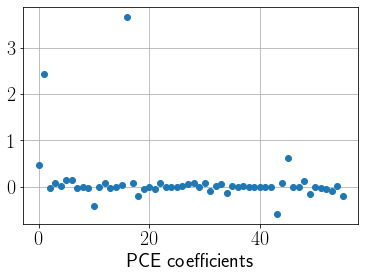

In [9]:
# Now to compute the PCE coefficients, first estimating norms of polynomials
#polynomial_norms = np.sum(np.multiply(sampled_polynomials, sampled_polynomials), axis=1)/N # estimates the 2 norm
# Remember, the norms of the Hermite polynomials are just factorials of the order
polynomial_norms = get_polynomial_norms(multiindices, 'hermite')
# Legendre norms: 2/(2*order + 1)
    
# Now estimate each normalized PCE coefficient
pce_coef = np.matmul(sampled_polynomials, f_Ishigami) / polynomial_norms / N
plt.plot(pce_coef, 'o')
plt.xlabel('PCE coefficients'); plt.grid()

In [10]:
# We already have sampled the MOPs, so I will use those samples instead for PDF reconstruction
pce_evals = np.dot(pce_coef, sampled_polynomials) # this runs all samples through the PCE transformation
ishigami_evals = [Ishigami(samples[:,i]) for i in range(N)]
# See how they agree at some random point
print('PCE      at [.25, .5, .75]: ', evaluate_pce(pce_coef, multiindices, 'hermite', [.25,.5,.75]))
print('Ishigami at [.25, .5, .75]: ', Ishigami([.25,.5,.75]))
print('Average error in total PCE: ',np.sum(np.abs(pce_evals - ishigami_evals))/N)

PCE      at [.25, .5, .75]:  1.081166939278953
Ishigami at [.25, .5, .75]:  0.5555329653033295
Average error in total PCE:  0.6794058884139719


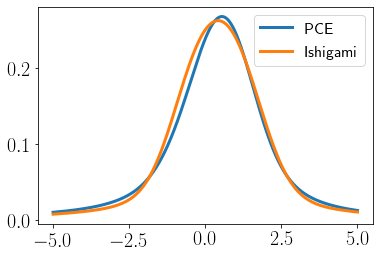

In [11]:
# Plot both PDFs together to see how well the PCE approximates the Ishigami response
x_pts = np.linspace(-5.0,5.0,1000)
plt.plot(x_pts, gaussian_kde(pce_evals)(x_pts))
plt.plot(x_pts, gaussian_kde(ishigami_evals)(x_pts))
plt.legend(['PCE','Ishigami'])

### Let's try modeling the uncertain parameters in Ishigami with uniform RVs
#### We use uniform RVs ~$U[-\pi, \pi]$ and the same constants as the 2009 paper of LeMaitre. Our results below are consistent

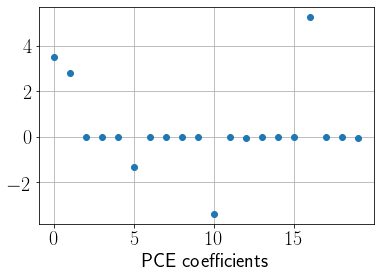

In [9]:
# Put together an array of random samples and initialize variables
multiindices_unif = pya.compute_hyperbolic_indices(3, 3)
P = multiindices_unif.shape[1]

N_unif = 1000000
#samples = np.random.normal(0.,1.,(3, N))
#samples_unif = np.random.uniform(-1.0, 1.0, (3,N_unif))
A = -np.pi; B = np.pi; a = 7.0; b = 0.1 # these are uniform bounds and Ishigami constants
samples_unif_ab = np.random.uniform(A, B, (3,N_unif))
samples_unif = transf_uniform(samples_unif_ab, A, B) # maps RVs to the interval [-1, 1]
sampled_polynomials_unif = np.zeros((P, N_unif))
f_Ishigami_unif = np.array([])

# Then here's the expensive step, sample the orthogonal polynomials and the QoI
for i in range(N_unif):
    sampled_polynomials_unif[:,i] = evaluate_orthogonal_polynomials(multiindices_unif, samples_unif[:,i], 'legendre')
    f_Ishigami_unif = np.append(f_Ishigami_unif, Ishigami(samples_unif_ab[:,i], a, b))
    
# Now to compute the PCE coefficients, first estimating norms of polynomials
#polynomial_norms_unif = np.sum(np.multiply(sampled_polynomials_unif, sampled_polynomials_unif), axis=1)/N_unif # estimates the 2 norm
polynomial_norms_unif = get_polynomial_norms(multiindices_unif, 'legendre')
    
# Now estimate each normalized PCE coefficient
pce_coef_unif = np.matmul(sampled_polynomials_unif, f_Ishigami_unif) / polynomial_norms_unif / N_unif
plt.plot(pce_coef_unif, 'o')
plt.xlabel('PCE coefficients'); plt.grid()

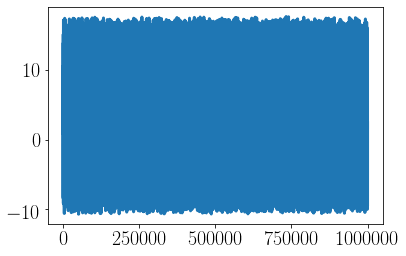

In [38]:
plt.plot(f_Ishigami_unif)

array([[0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 3, 0, 0, 2, 1, 2, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 3, 0, 1, 2, 0, 0, 2, 1, 1],
       [0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 3, 0, 0, 1, 2, 1, 2, 1]])

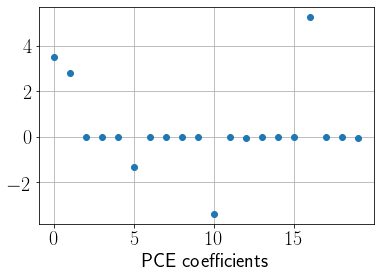

In [17]:
plt.plot(pce_coef_unif[:20], 'o')
plt.xlabel('PCE coefficients'); plt.grid()
np.round_(pce_coef_unif[:20], 2)
multiindices

PCE      at [.25, .5, .75]:  1.947640422354096
Ishigami at [.25, .5, .75]:  1.8641739046143218
Average error in total PCE:  0.401010030451848


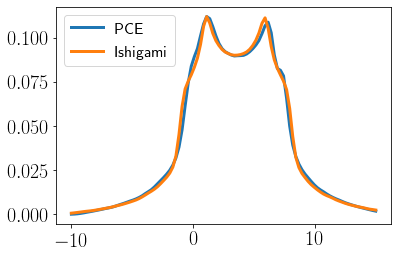

In [72]:
# We already have sampled the MOPs, so I will use those samples instead for PDF reconstruction
pce_evals_unif = np.dot(pce_coef_unif, sampled_polynomials_unif) # this runs all samples through the PCE transformation
ishigami_evals_unif = [Ishigami(samples_unif_ab[:,i], a, b) for i in range(N_unif)]
# See how they agree at some random point
rand_in_standardint = transf_uniform(np.array([.25,.5,.75]), A, B)
print('PCE      at [.25, .5, .75]: ', evaluate_pce(pce_coef_unif, multiindices_unif, 'legendre', rand_in_standardint))
print('Ishigami at [.25, .5, .75]: ', Ishigami([.25,.5,.75], a, b))
print('Average error in total PCE: ',np.sum(np.abs(pce_evals_unif - ishigami_evals_unif))/N_unif)

# This is with a total polynomial order of 6
x_pts = np.linspace(-10.0,15.0,100)
#plt.hist(pce_evals_unif, alpha=.5)
#plt.hist(ishigami_evals_unif, alpha=.5)
plt.plot(x_pts, gaussian_kde(pce_evals_unif)(x_pts))
plt.plot(x_pts, gaussian_kde(ishigami_evals_unif)(x_pts))
plt.legend(['PCE','Ishigami'])

In [74]:
get_sobol_using_pce(multiindices_unif, pce_coef_unif,'legendre');

# The Pyapprox Sobol codes only work for orthonormal families of polynomials, just be aware of this

var:  13.537247477127366
first order:  [0.32080123290166473, 0.44117311593512004, 4.701610771543347e-05]
total indices:  [0.5587637264528944, 0.44125530410883007, 0.23798469511851972]


### Let's try another test example with the 2D Rosenbrock function. Answers can be generated with Dakota

## This code takes a while to run because I have made a double loop that collects NN realizations of the PCE coefficients and plots them below. 

In [65]:
# Number of outer iterations
NN = 5000
PCE_COEF = sampled_polynomials_rosen = np.zeros((21, NN))
for j in range(NN):

    # It's a function of 2 variables, so let's define multi-indces. First a subset of the MIs
    multiindices_rosen = pya.compute_hyperbolic_indices(2,5)
    P_rosen = multiindices_rosen.shape[1] # the number of expansion terms

    N_rosen = 10000
    samples_rosen = np.random.normal(0,1,(3, N_rosen))
    sampled_polynomials_rosen = np.zeros((P_rosen, N_rosen))
    f_rosen = np.array([])

    # Sample the orthogonal polynomials and the QoI
    for i in range(N_rosen):
        sampled_polynomials_rosen[:,i] = evaluate_orthogonal_polynomials(multiindices_rosen, samples_rosen[:,i], 'hermite')
        f_rosen = np.append(f_rosen, rosenbrock(samples_rosen[:,i]))

    # Now to compute the PCE coefficients, first estimating norms of polynomials
    polynomial_norms_rosen = get_polynomial_norms(multiindices_rosen, 'hermite') # analytic values
    # Now estimate each normalized PCE coefficient
    pce_coef_rosen = np.matmul(sampled_polynomials_rosen, f_rosen) / polynomial_norms_rosen / N_rosen
    
    PCE_COEF[:,j] = pce_coef_rosen
#plt.plot(pce_coef_rosen, 'o')
#plt.xlabel('PCE coefficients'); plt.grid()
# Evaluating the new PCE with more terms
#rosen_evals = [rosenbrock(samples_rosen[:,i]) for i in range(N_rosen)]
#pce_evals_rosen = np.dot(pce_coef_rosen, sampled_polynomials_rosen) # this runs all samples through the PCE transformation

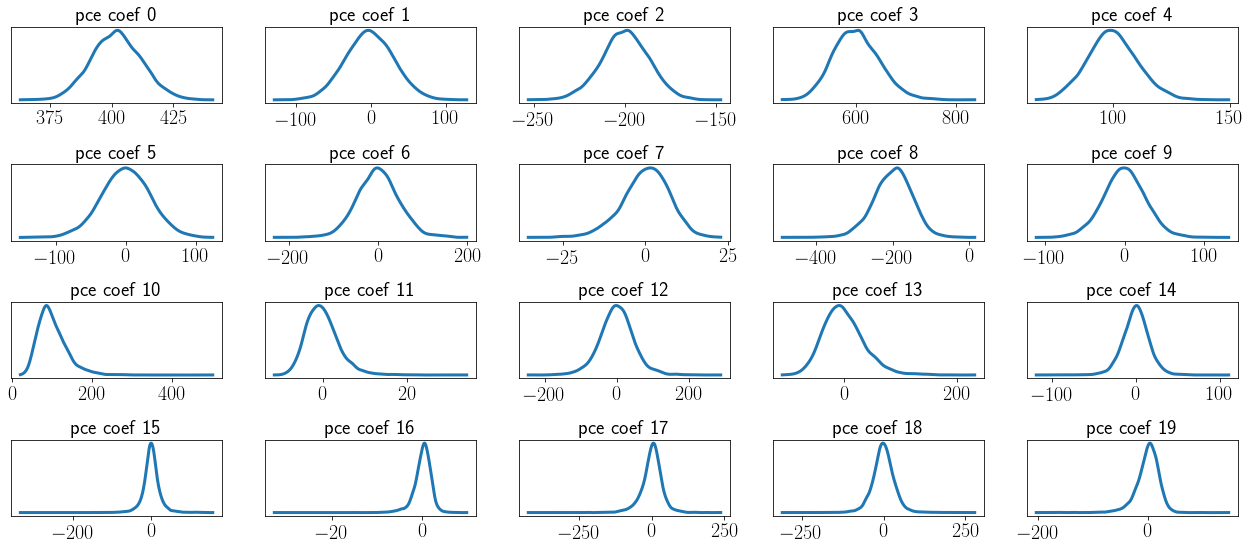

In [124]:
# Create a subplot figure
fig, axs = plt.subplots(4,5, figsize=(22, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .8, wspace=.2)
axs = axs.ravel()

for i in range(20):
    data = PCE_COEF[i,:]
    x_pts = np.linspace(min(data),max(data),1000)
    axs[i].plot(x_pts, gaussian_kde(data)(x_pts))
    axs[i].set_title('pce coef %d' %i)
    
for ax in axs:
    ax.set_yticks([])
    
#plt.savefig('rosenbrock_normal_20')

In [19]:
# here we check if the PCE coefficients match the output from Dakota
#   4.02e+02  He0  He0
#  -2.00e+00  He1  He0
#   6.01e+02  He2  He0
#   1.00e+02  He4  He0
#  -2.00e+02  He0  He1
#  -2.00e+02  He2  He1
#   1.00e+02  He0  He2
print(multiindices_rosen[:, [0,1,3,10,2,8,4]])
print(pce_coef_rosen[0,1,3,10,2,8,4])

[[0 1 2 4 0 2 0]
 [0 0 0 0 1 1 2]]
[ 4.02981859e+02 -5.53096869e-01  6.06027809e+02  1.03552215e+02
 -1.99230930e+02 -1.96134025e+02  9.89339712e+01]


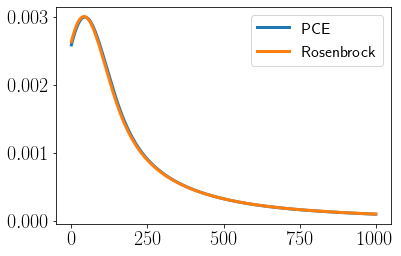

In [20]:
x_pts = np.linspace(0,1000,1000)
plt.plot(x_pts, gaussian_kde(pce_evals_rosen)(x_pts))
plt.plot(x_pts, gaussian_kde(rosen_evals)(x_pts))
plt.legend(['PCE','Rosenbrock'])

In [26]:
# this is the Pyapprox routine, they want the PCE coefficients to be a 2D array
# Here is a hack, let PCE coeffs = np.transpose(pce_coef[np.newaxis])
# BOTH OF THESE WORK NICELY, but again, they assume the polynomials are orthonormal
pya.get_main_and_total_effect_indices_from_pce(np.transpose(pce_coef_rosen_full[np.newaxis]), multiindices_rosen_full)
pya.get_sobol_indices(np.transpose(pce_coef_rosen_full[np.newaxis]), multiindices_rosen_full)


(array([array([0]), array([1]), array([0, 1])], dtype=object),
 array([[0.79652594],
        [0.10971584],
        [0.09375822]]))

### More Dakota validation tests: Rosenbrock ~ U[-1, 1], Ishigami ~ N(0,1), and Ishigami~U[-1,1]

[[0 1 0 2 0 1 3 0 2 1 4 0 3 2 1 5 0 4 3 2 1]
 [0 0 1 0 2 1 0 3 1 2 0 4 1 2 3 0 5 1 2 3 4]]
PCE coefficients:  [ 5.45873744e+01 -2.05686529e+00 -6.65265935e+01  5.77562961e+01
  6.66255536e+01  2.01435625e-01  1.87171061e-01  5.25622751e-03
 -1.32743755e+02  3.32777773e-01  2.26258813e+01  1.54119160e-01
 -1.09508298e+00 -3.90143270e-01 -1.05316397e+00  8.77166327e-01
  1.37189082e-01  7.46347958e-01  1.17026629e+00  5.84791237e-02
  2.66354411e+00]
Sobol Indices: 
var:  4263.761556522154
first order:  [0.170160617216689, 0.5542194958676563]
total indices:  [0.44578050413234377, 0.8298393827833112]
(4263.761556522154, [0.170160617216689, 0.5542194958676563], [0.44578050413234377, 0.8298393827833112])


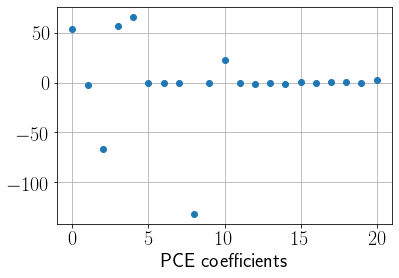

In [48]:
# Now I'll just compute the PCE without taking a subset of the multi-indices
multiindices_rosen = pya.compute_hyperbolic_indices(2,5)
P_rosen = multiindices_rosen.shape[1] # the number of expansion terms

N_rosen = 500000
samples_rosen = np.random.uniform(-1.0,1.0,(2, N_rosen))
sampled_polynomials_rosen = np.zeros((P_rosen, N_rosen))
f_rosen = np.array([])

# Sample the orthogonal polynomials and the QoI
for i in range(N_rosen):
    sampled_polynomials_rosen[:,i] = evaluate_orthogonal_polynomials(multiindices_rosen, samples_rosen[:,i], 'legendre')
    f_rosen = np.append(f_rosen, rosenbrock(samples_rosen[:,i]))

# Now to compute the PCE coefficients, first estimating norms of polynomials
polynomial_norms_rosen = get_polynomial_norms(multiindices_rosen, 'legendre') # analytic values
# Now estimate each normalized PCE coefficient
pce_coef_rosen = np.matmul(sampled_polynomials_rosen, f_rosen) / polynomial_norms_rosen / N_rosen
plt.plot(pce_coef_rosen, 'o')
plt.xlabel('PCE coefficients'); plt.grid()
# Evaluating the new PCE with more terms
rosen_evals = [rosenbrock(samples_rosen[:,i]) for i in range(N_rosen)]
pce_evals_rosen = np.dot(pce_coef_rosen, sampled_polynomials_rosen) # this runs all samples through the PCE transformation

print(multiindices_rosen)
print('PCE coefficients: ', pce_coef_rosen)
print('Sobol Indices: ')
print(get_sobol_using_pce(multiindices_rosen, pce_coef_rosen, 'legendre'))

### I noticed that for these next 2 examples (both Ishigami), you need to sample the function quite a bit (>10^5 times) to accurately resolve the PCE coefficients and the Sobol indices. I also didn't see good results until I computed a large number of PCE coefficients, sometimes up to 200 or a total polynomial order of about 10.

PCE coefficients:  [ 3.50614124e+00  5.73728600e+01 -2.86179885e-02  2.95331746e-02
 -1.06325513e-01 -5.93424540e-01 -3.42376484e-02 -1.14327577e+00
 -1.26827063e+02  1.39958715e-01  8.21272236e+01  3.22653244e-01
 -7.41757448e-02 -1.42873189e-01 -4.16949292e-01 -7.21687271e-02
  1.17163986e+02  7.68838145e-01 -3.32494819e-01  2.68880265e+00
  2.58641615e-01 -1.73393252e+00  3.15007272e-01  7.81309053e-01
  3.00642742e-01 -9.38001830e-03 -1.81415241e+02  8.49415094e-01
 -5.95129989e+01 -5.20633135e-01 -1.21939340e+00  5.44658162e-01
  6.23595867e-01  7.52001914e-01 -2.72605535e+00 -2.20467119e+02
 -1.87343008e-01 -3.70717949e-01 -1.19902435e-02 -2.18269984e-01
 -5.39223478e-01 -1.02086571e+00 -2.99974229e-01  1.67262269e+02
 -1.70055142e+00  1.67960964e+01 -7.11153330e-01  3.79393604e-02
  1.49789938e+00 -5.77688415e-01 -1.69576094e+00 -8.50307992e-01
  2.87386949e-01 -1.53216868e+00 -3.52225482e-01  1.29464273e+00
 -7.53801076e-02 -3.74040421e+00 -1.69669870e-01  1.86315192e-01
 -3.73

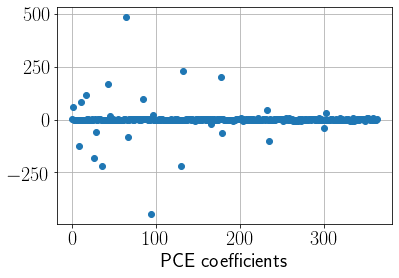

In [158]:
# Computing: Ishigami_Dakota and U[-1, 1] for inputs
multiindices = pya.compute_hyperbolic_indices(3,11)
P = multiindices.shape[1] # the number of expansion terms

N = 1000000
samples = np.random.uniform(-1.0,1.0,(3, N))
sampled_polynomials = np.zeros((P, N))
f = np.array([])

# Sample the orthogonal polynomials and the QoI
for i in range(N):
    sampled_polynomials[:,i] = evaluate_orthogonal_polynomials(multiindices, samples[:,i], 'legendre')
    f = np.append(f, Ishigami_Dakota(samples[:,i]))

# Now to compute the PCE coefficients, first estimating norms of polynomials
polynomial_norms = get_polynomial_norms(multiindices, 'legendre') # analytic values
# Now estimate each normalized PCE coefficient
pce_coef = np.matmul(sampled_polynomials, f) / polynomial_norms / N
plt.plot(pce_coef, 'o')
plt.xlabel('PCE coefficients'); plt.grid()
# Evaluating the new PCE with more terms
f_evals = [Ishigami_Dakota(samples[:,i]) for i in range(N)]
pce_evals = np.dot(pce_coef, sampled_polynomials) # this runs all samples through the PCE transformation

#print(multiindices)
#print('PCE coefficients: ', pce_coef)
print('Sobol Indices: ')
print(get_sobol_using_pce(multiindices, pce_coef, 'legendre'))

PCE coefficients:  [ 3.73875086e+00  7.42335178e-01  1.26213572e+00 -2.79637567e+00
  5.68850226e-01  1.81980610e+00  1.29465280e+00  4.97035125e-01
 -5.72299372e-01 -4.28460665e+00 -1.29003587e+00  9.88580929e-01
 -4.23344385e+00  5.89117574e-01  1.07704649e+00 -1.21664917e+00
  1.09344884e+00 -4.88193650e+00  6.65199304e+00 -1.18249520e+00
  1.35791677e-01  6.51885560e-02  7.59754607e-01  2.09444139e-01
 -1.00947360e+00 -2.77627745e-02  2.00116573e+00  1.56583608e-01
 -2.41951632e-01 -2.08540024e+00  7.24732838e+00 -7.41678067e+00
 -2.96850095e+00 -4.86135966e+00  5.55460649e+00 -1.06744372e-01
  2.88325894e-01 -1.62836029e+00  3.00315408e-01  1.33213235e-01
 -4.93469136e-01 -3.21058755e-01 -8.77669566e-01 -4.14466272e+00
  1.06231304e-01  1.62416456e+00  1.00772811e-01  1.08878729e+00
 -6.41060374e+00  4.51449397e+00 -1.48112518e+00  6.64322002e-01
 -2.90765599e-01  5.70964118e+00  4.68057864e+00 -3.10975963e+00
  2.05402394e-02 -3.70153215e-02  4.31288238e-01 -2.49772516e-02
  1.34

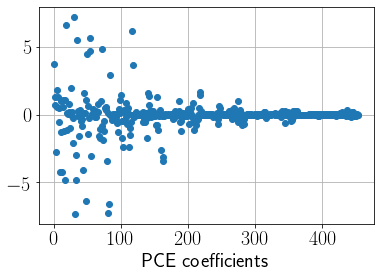

In [161]:
# Computing: Ishigami_Dakota and N(0,1) for inputs
multiindices = pya.compute_hyperbolic_indices(3,12)
P = multiindices.shape[1] # the number of expansion terms

N = 2000000
samples = np.random.normal(0.0,1.0,(3, N))
sampled_polynomials = np.zeros((P, N))
f = np.array([])

# Sample the orthogonal polynomials and the QoI
for i in range(N):
    sampled_polynomials[:,i] = evaluate_orthogonal_polynomials(multiindices, samples[:,i], 'hermite')
    f = np.append(f, Ishigami_Dakota(samples[:,i]))

# Now to compute the PCE coefficients, first estimating norms of polynomials
polynomial_norms = get_polynomial_norms(multiindices, 'hermite') # analytic values
# Now estimate each normalized PCE coefficient
pce_coef = np.matmul(sampled_polynomials, f) / polynomial_norms / N
plt.plot(pce_coef, 'o')
plt.xlabel('PCE coefficients'); plt.grid()
# Evaluating the new PCE with more terms
f_evals = [Ishigami_Dakota(samples[:,i]) for i in range(N)]
pce_evals = np.dot(pce_coef, sampled_polynomials) # this runs all samples through the PCE transformation

#print(multiindices)
#print('PCE coefficients: ', pce_coef)
print('Sobol Indices: ')
print(get_sobol_using_pce(multiindices, pce_coef, 'hermite'))